## Introduction

Assignment:

**Predict whether a failure of a Scania Truck component is related to the air pressure system (APS) or not.**

Evaluation:

**The evaluation metric is the ROC-AUC score** 

Data:

A set of anonymized features that were collected from heavy Scania Trucks at everyday usage.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, plot_roc_curve, recall_score, precision_score, f1_score

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

from joblib import dump, load

## Data

### Exploration

In [3]:
# Data has 20 rows of description at the start, missing values coded as 'na'

train = pd.read_csv('/content/drive/My Drive/Colab/scania_challenge/data/aps_failure_training_set.csv', skiprows=20, na_values='na')
test = pd.read_csv('/content/drive/My Drive/Colab/scania_challenge/data/aps_failure_test_set.csv', skiprows=20, na_values='na')

In [4]:
# class coded as 'pos' and 'neg', replacing with 1 and 0

train['class'].replace(['pos', 'neg'], [1,0], inplace=True)
test['class'].replace(['pos', 'neg'], [1,0], inplace=True)

In [5]:
train.shape

(60000, 171)

In [6]:
train.describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.935500e+04,5.937100e+04,5.937100e+04,5.560000e+04,5.935800e+04,5.937100e+04,5.935800e+04,5.941100e+04,5.935800e+04,5.941100e+04,57277.000000,5.937100e+04,5.937100e+04,5.937100e+04,57500.000000,57499.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,...,46192.000000,4.619200e+04,57497.000000,57276.000000,5.599200e+04,5.599200e+04,5.599200e+04,5.599400e+04,55993.000000,5.599300e+04,5.599200e+04,5.599100e+04,5.930900e+04,5.727600e+04,57274.000000,5.727400e+04,5.727400e+04,5.727300e+04,57273.000000,5.727400e+04,5.727400e+04,5.727700e+04,5.727600e+04,57277.000000,57277.000000,5.599300e+04,49761.000000,50447.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,0.016667,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,1.108374e+06,1.657818e+06,4.993098e+05,3.556989e+04,5.114753e+03,1.809931e+06,9.016965e+03,1.143675e+03,9.794900e+02,5.913048e+04,9.328133e+04,3.461037e+06,3.002440e+06,1.004160e+06,4.424045e+05,0.496918,1.267365e+02,5.072046e+03,2.305804e+02,1117.825913,374.327380,1.221165e+04,1.019012e+04,1.097500e+04,7.225784e+03,1.056600e+04,1.119791e+05,1.078551e+06,...,13.416652,2.200752e+06,3123.961911,375.147112,2.718638e+03,5.609957e+03,4.707073e+03,3.724824e+04,39.938564,1.861313e+03,2.854177e+04,7.923228e+03,3.374545e+04,2.850785e+04,6958.652722,4.529375e+06,2.037598e+05,8.965500e+04,15403.354670,4.058712e+06,5.938350e+05,7.912085e+05,7.780350e+03,0.215759,1.567750,9.717093e+06,1353.131452,1452.155212,7.334042e+05,7.838746e+05,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,0.128020,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,7.617312e+05,2.374282e+06,3.262607e+06,3.909384e+06,1.422765e+06,2.201524e+05,1.696582e+05,4.185740e+06,1.632778e+05,5.035971e+04,7.583162e+04,5.394658e+05,8.494694e+05,7.790350e+06,6.819518e+06,3.088457e+06,1.262469e+06,5.511653,1.101004e+04,1.196159e+05,1.579952e+04,6598.611557,1482.711621,4.544963e+05,5.352707e+05,4.283370e+05,2.064679e+05,3.546258e+05,1.394585e+06,3.278941e+06,...,73.405610,4.110150e+06,9516.675102,1689.062059,1.373331e+05,2.085649e+05,5.602799e+05,4.254382e+05,4533.142182,6.659786e+04,1.095662e+06,2.775356e+05,9.733719e+04,6.125476e+04,13955.451781,9.748478e+07,1.366065e+06,2.082016e+05,33801.022975,1.156777e+07,2.082998e+06,4.151033e+06,5.924449e+04,10.821035,53.528722,4.274675e+07,3536.637285,3525.028652,2.416166e+06,2.570111e+06,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000

In [7]:
train.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 171 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   class   60000 non-null  int64  
 1   aa_000  60000 non-null  int64  
 2   ab_000  13671 non-null  float64
 3   ac_000  56665 non-null  float64
 4   ad_000  45139 non-null  float64
 5   ae_000  57500 non-null  float64
 6   af_000  57500 non-null  float64
 7   ag_000  59329 non-null  float64
 8   ag_001  59329 non-null  float64
 9   ag_002  59329 non-null  float64
 10  ag_003  59329 non-null  float64
 11  ag_004  59329 non-null  float64
 12  ag_005  59329 non-null  float64
 13  ag_006  59329 non-null  float64
 14  ag_007  59329 non-null  float64
 15  ag_008  59329 non-null  float64
 16  ag_009  59329 non-null  float64
 17  ah_000  59355 non-null  float64
 18  ai_000  59371 non-null  float64
 19  aj_000  59371 non-null  float64
 20  ak_000  55600 non-null  float64
 21  al_000  59358 non-null  float64
 2

### Missing values

High number of null values in the data. Getting an idea percentage-wise per column:

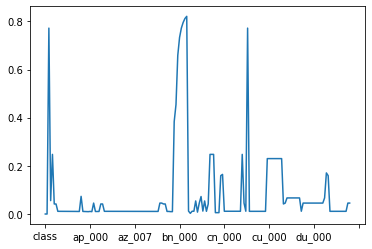

In [8]:
train.isna().mean().plot();

Based on this plot I decided to drop columns that have >20% missing values. Usually this decision would be based on some domain knowledge, but the columns here are anonymized.

In [9]:
dropped_columns = train.loc[:, train.isna().mean() > 0.2].columns

In [10]:
train.drop(columns=dropped_columns, inplace= True)
test.drop(columns=dropped_columns, inplace= True)

In [11]:
train.shape

(60000, 147)

### Dimensionality

High-dimensional data can negatively impact the performance of ML algorithms and increases the volume of data needed to make accurate predictions exponentially. 

Having this many features also makes me worry that there may be some multi-collinearity. This can cause problems (overfitting, affects statistical significance) in linear models especially and can be an indication that dimensionality reduction may be warranted. I will check for this first.

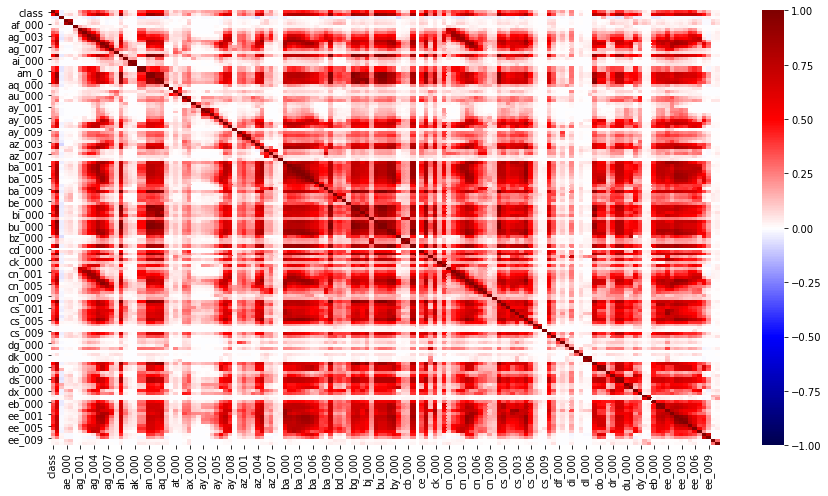

In [12]:
plt.figure(figsize=(15,8))
sns.heatmap(train.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

The heatmap shows very strong correlation between many of our features. This data can likely be represented in less dimensions than it currently has.

In [13]:
X = train.drop(columns='class')
y = train['class']
X_test = test.drop(columns='class')
y_test = test['class']

In [ ]:
imp = SimpleImputer(strategy='median')
X_imputed = imp.fit_transform(X)
scale = StandardScaler()
X_scaled = scale.fit_transform(X_imputed)
pca = PCA(n_components = 0.95)
pca.fit(X_scaled)
reduced = pca.transform(X_scaled)

In [ ]:
pca.n_components_

71

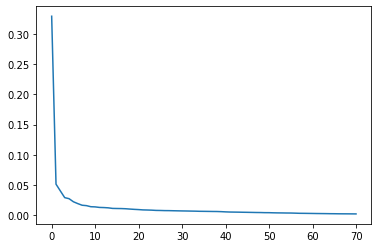

In [ ]:
plt.plot(range(pca.n_components_), pca.explained_variance_ratio_)

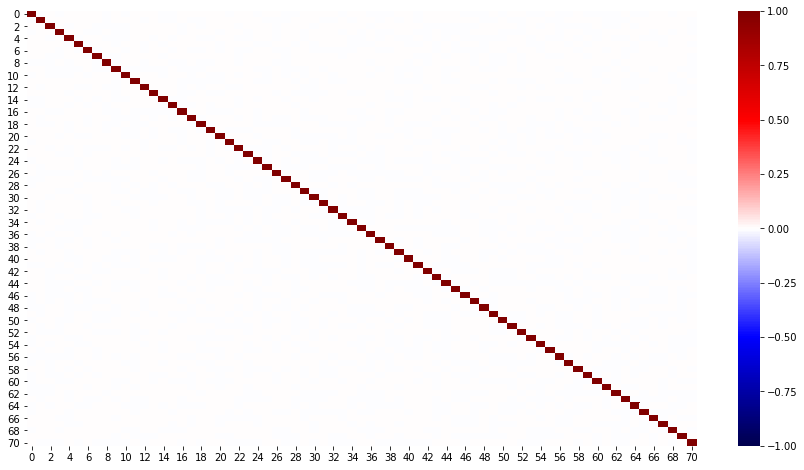

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(pd.DataFrame(reduced).corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

No more collinearity should help linear models perform better and less features make model execution more efficient.

### PCA impact baseline
Creating a baseline score to test impact of dimensionality reduction

In [ ]:
baseline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), LogisticRegression())
round(np.mean(cross_val_score(baseline, X, y, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)),3)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   28.7s finished


0.97

In [ ]:
pca_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), PCA(n_components = 0.95), LogisticRegression())
round(np.mean(cross_val_score(pca_pipeline, X, y, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)),3)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   33.9s finished


0.965

### Class imbalance

Checking for class imbalance in the data

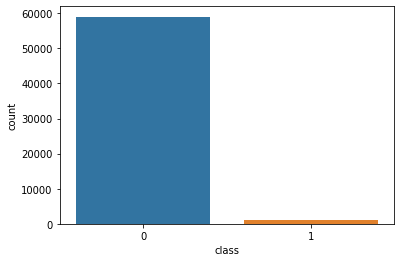

In [ ]:
sns.countplot(x='class', data=train);

In [ ]:
train['class'].value_counts()

0    59000
1     1000
Name: class, dtype: int64

In [ ]:
train['class'].value_counts()[1]/train['class'].value_counts()[0]

0.01694915254237288

The positive class (failure is related to APS) makes up less than 2% of the data set. It will be worth testing oversampling to try and improve model performance.

## Model selection

From the previous sections it is clear that this is a high-dimensional and very imbalanced dataset. I will test multiple classification algorithms as well as PCA and oversampling to find the preprocessing steps and model(s) that perform well on this data. Then I will select the best performing ones and tune them for optimal performance in the next section.

In [ ]:
estimators = {'Logistic Regression': LogisticRegression(), 'Random Forest': RandomForestClassifier(), 'Naive Bayes': GaussianNB(), 'XGBoost': XGBClassifier()}

In [ ]:
def get_score(X, y, name, estimator):
    '''
    Get cross validation scores for multiple pipelines with single estimator
    Inputs:
    X, y: features, target
    name: string, name of estimator
    estimator: estimator object to be fed into pipeline
    '''
    imputed = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), estimator)
    oversampled = make_pipeline(SimpleImputer(strategy='median'),  
                                StandardScaler(), SMOTE(sampling_strategy=0.15), estimator)
    reduced = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), 
                            PCA(n_components = 0.95), estimator)
    reduced_oversampled = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), 
                                        SMOTE(sampling_strategy=0.15), PCA(n_components = 0.95), estimator)
    
    pipelines = {'imputed': imputed, 'oversampled': oversampled, 'reduced': reduced, 
                 'reduced_oversampled': reduced_oversampled}
    
    for key, pipe in pipelines.items():
        score = cross_val_score(pipe, X, y, scoring='roc_auc', cv=10, verbose=0, n_jobs=-1)
        print(f'{name} {key} roc_auc: {score.mean():.3f} (+/- {score.std():.3f})')

In [ ]:
for key, estimator in estimators.items():
    get_score(X, y, key, estimator)

Logistic Regression imputed roc_auc: 0.970 (+/- 0.014)
Logistic Regression oversampled roc_auc: 0.966 (+/- 0.019)
Logistic Regression reduced roc_auc: 0.965 (+/- 0.012)
Logistic Regression reduced_oversampled roc_auc: 0.971 (+/- 0.015)
Random Forest imputed roc_auc: 0.986 (+/- 0.008)
Random Forest oversampled roc_auc: 0.990 (+/- 0.006)
Random Forest reduced roc_auc: 0.981 (+/- 0.008)
Random Forest reduced_oversampled roc_auc: 0.988 (+/- 0.005)
Naive Bayes imputed roc_auc: 0.963 (+/- 0.009)
Naive Bayes oversampled roc_auc: 0.961 (+/- 0.012)
Naive Bayes reduced roc_auc: 0.970 (+/- 0.004)
Naive Bayes reduced_oversampled roc_auc: 0.969 (+/- 0.006)
XGBoost imputed roc_auc: 0.990 (+/- 0.005)
XGBoost oversampled roc_auc: 0.988 (+/- 0.004)
XGBoost reduced roc_auc: 0.986 (+/- 0.004)
XGBoost reduced_oversampled roc_auc: 0.988 (+/- 0.004)


## Tuning


Random Forest and XGBoost outperformed the other models without any tuning. I'll pick those two to to try and tune the hyperparameters some more to improve performance even further. Random Forest seems to benefit slightly from oversampling and XGBoost does best with just the base (imputed) data

### Random Forest

In [ ]:
rf = Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler()), ('smote', SMOTE()), ('rf', RandomForestClassifier())])

In [ ]:
params = {'smote__sampling_strategy': [0.15, 0.5, 1],
          'rf__max_depth': [2, 3, 5, 10],
          'rf__n_estimators': [50, 100, 200]}

In [ ]:
rf_grid = GridSearchCV(rf, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=5)

In [ ]:
rf_grid.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('sc',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='depr

In [ ]:
rf_grid.best_estimator_

Pipeline(memory=None,
         steps=[('imp',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('sc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_str...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                  

In [ ]:
rf_grid.best_score_

0.9890458474576272

In [ ]:
rf_grid.best_params_

{'rf__max_depth': 10,
 'rf__n_estimators': 100,
 'smote__sampling_strategy': 0.15}

### XGBoost

In [16]:
imp = SimpleImputer(strategy='median')
X_imputed = imp.fit_transform(X)

In [ ]:
xgb = XGBClassifier(n_estimators=1000)

In [ ]:
params = {'xgb__max_depth': [2, 4, 6, 8, 10, 12],
          'xgb__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
          'xgb__min_child_weight': [1, 3, 5],
          'xgb__gamma': [0.0, 0.1, 0.2, 0.3, 0.5, 0.8, 1, 5],
          'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]}

In [ ]:
xgb_searchcv = RandomizedSearchCV(xgb, cv=5, param_distributions=params, n_iter=20, n_jobs=-1)
xgb_searchcv.fit(X_imputed, y, early_stopping_rounds= 10, eval_set=[[X_imputed, y]], eval_metric='auc') 

[0]	validation_0-auc:0.92366
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.932216
[2]	validation_0-auc:0.933748
[3]	validation_0-auc:0.933793
[4]	validation_0-auc:0.93901
[5]	validation_0-auc:0.942659
[6]	validation_0-auc:0.947966
[7]	validation_0-auc:0.948142
[8]	validation_0-auc:0.955352
[9]	validation_0-auc:0.968113
[10]	validation_0-auc:0.970225
[11]	validation_0-auc:0.971256
[12]	validation_0-auc:0.975814
[13]	validation_0-auc:0.975856
[14]	validation_0-auc:0.977788
[15]	validation_0-auc:0.977865
[16]	validation_0-auc:0.978052
[17]	validation_0-auc:0.978159
[18]	validation_0-auc:0.978244
[19]	validation_0-auc:0.978289
[20]	validation_0-auc:0.979288
[21]	validation_0-auc:0.979325
[22]	validation_0-auc:0.980333
[23]	validation_0-auc:0.980386
[24]	validation_0-auc:0.980445
[25]	validation_0-auc:0.982685
[26]	validation_0-auc:0.984541
[27]	validation_0-auc:0.984569
[28]	validation_0-auc:0.984897
[29]	validation_0-auc:0.985041
[30]	validation_0-

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=1000,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, s...
                   iid='deprecated', n_iter=20, n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.6, 0.7, 0.8,
                                     

In [ ]:
xgb_searchcv.best_params_

{'xgb__colsample_bytree': 0.9,
 'xgb__gamma': 5,
 'xgb__learning_rate': 0.2,
 'xgb__max_depth': 6,
 'xgb__min_child_weight': 3}

In [ ]:
xgb_searchcv.best_score_

0.9941333333333333

## Final model

The XGBoost model performed the best, so I will take the results from the hyperparameter search and train my final model, testing it on the held out test data.

At this point I will also start looking at a secondary metric. roc_auc is the asked for metric, but to actually use this model I will need to set a threshold for final predictions.

In this case, a false positive means that the cause of a failure is falsely identified as the APS, causing a possibly unnecessary check. A false negative means that the APS is missed as the true cause of the failure, which could cause a faulty truck to be cleared or many unnecessary checks in other areas. I believe a false negative is more costly (or causes higher risk), so I will be looking at recall as my second metric.

In [17]:
xgb = XGBClassifier(max_depth=6, learning_rate=0.2, gamma=5, min_child_weight=3, colsample_bytree=0.9)

In [18]:
cross_validate(xgb, X_imputed, y, scoring=['roc_auc', 'recall'], cv=10, n_jobs=-1, return_train_score=True)

{'fit_time': array([104.77226377, 104.90896177,  99.449296  ,  99.71232462,
         97.55728388,  97.82327223, 103.32456565, 104.21799183,
        106.82505012, 106.91302299]),
 'score_time': array([0.06557298, 0.0595777 , 0.06796885, 0.06543303, 0.06629133,
        0.06856847, 0.064996  , 0.06150055, 0.06590748, 0.05096698]),
 'test_recall': array([0.73, 0.79, 0.74, 0.71, 0.77, 0.67, 0.7 , 0.79, 0.67, 0.75]),
 'test_roc_auc': array([0.98982373, 0.99169746, 0.98914068, 0.9919    , 0.99078983,
        0.98115847, 0.98827373, 0.99526102, 0.99592881, 0.99186441]),
 'train_recall': array([0.89333333, 0.88777778, 0.90444444, 0.90222222, 0.88888889,
        0.90555556, 0.89666667, 0.88666667, 0.89888889, 0.91222222]),
 'train_roc_auc': array([0.99845996, 0.99836355, 0.99828281, 0.9984985 , 0.99712757,
        0.99806409, 0.99811379, 0.99861722, 0.99848897, 0.99855694])}

In [19]:
xgb_pipeline = make_pipeline(SimpleImputer(strategy='median'), XGBClassifier(max_depth=6, learning_rate=0.2, gamma=5, min_child_weight=3, colsample_bytree=0.9))
xgb_pipeline.fit(X, y, xgbclassifier__early_stopping_rounds= 10, xgbclassifier__eval_set=[[X_imputed, y]], xgbclassifier__eval_metric='auc')

[0]	validation_0-auc:0.933127
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.96353
[2]	validation_0-auc:0.964595
[3]	validation_0-auc:0.967561
[4]	validation_0-auc:0.968164
[5]	validation_0-auc:0.973385
[6]	validation_0-auc:0.980274
[7]	validation_0-auc:0.983446
[8]	validation_0-auc:0.985121
[9]	validation_0-auc:0.985278
[10]	validation_0-auc:0.985404
[11]	validation_0-auc:0.986986
[12]	validation_0-auc:0.987077
[13]	validation_0-auc:0.988192
[14]	validation_0-auc:0.988328
[15]	validation_0-auc:0.988823
[16]	validation_0-auc:0.988826
[17]	validation_0-auc:0.989372
[18]	validation_0-auc:0.990393
[19]	validation_0-auc:0.990521
[20]	validation_0-auc:0.990643
[21]	validation_0-auc:0.99067
[22]	validation_0-auc:0.990717
[23]	validation_0-auc:0.993278
[24]	validation_0-auc:0.99326
[25]	validation_0-auc:0.99418
[26]	validation_0-auc:0.994348
[27]	validation_0-auc:0.994332
[28]	validation_0-auc:0.99439
[29]	validation_0-auc:0.994785
[30]	validation_0-auc

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=5, learning_rate=0.2,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=3, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

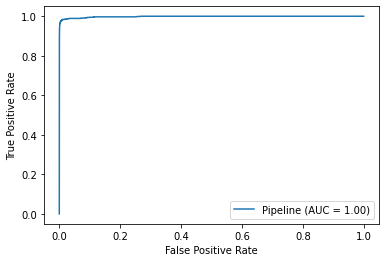

In [20]:
plot_roc_curve(xgb_pipeline, X, y)
plt.show();

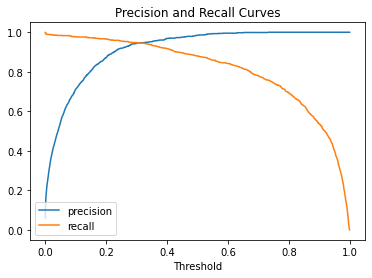

In [21]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y, xgb_pipeline.predict_proba(X)[:,1])
                                                                        
plt.figure()
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

Precision is high at low thresholds, but precision takes a sharp dive at really low thresholds. This graph means that the number of false positives goes up exponentially as the threshold is lowered. 

Setting the final threshold will have to be decided with business stakeholders.  

 **How many false positives would we accept to reduce the false negatives?**

In [22]:
threshold = 0.05
y_proba_test = xgb_pipeline.predict_proba(X_test)[:,1]
y_pred_test = (y_proba_test > threshold)
recall = recall_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
print(f'recall: {recall:.3f} | precision: {precision:.3f} | f1: {f1:.3f}')

recall: 0.936 | precision: 0.595 | f1: 0.727


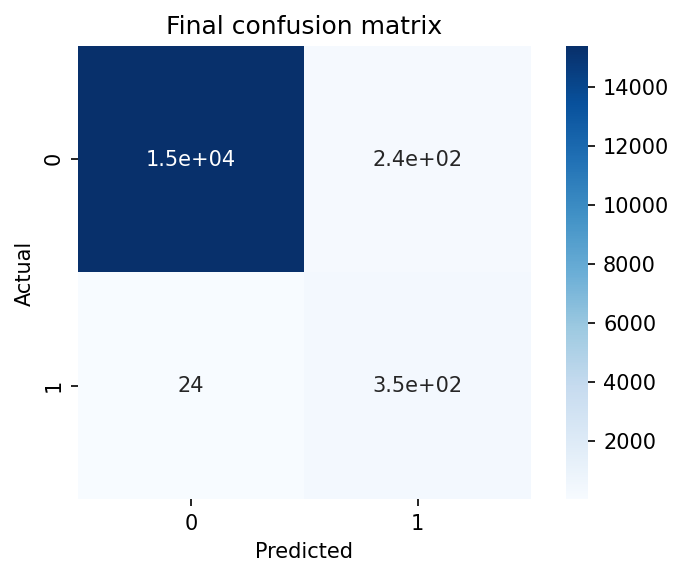

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(dpi=150)
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Final confusion matrix');

In [24]:
dump(xgb_pipeline, '/content/drive/My Drive/Colab/scania_challenge/xgb_model.joblib')

['/content/drive/My Drive/Colab/scania_challenge/xgb_model.joblib']

### Feature importance

XGBoost has several methods to investigate feature importance, which can help gain some insight from the model. Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model.

It is important to note that these scores are estimates, but they give some interpretability to these ensemble methods.

The default feature importance in XGBoost uses 'weight', or the number of times a feature appears in a tree in the model. This can be problematic when using categorical data, especially with high cardinality, but in this case almost all features are numeric.

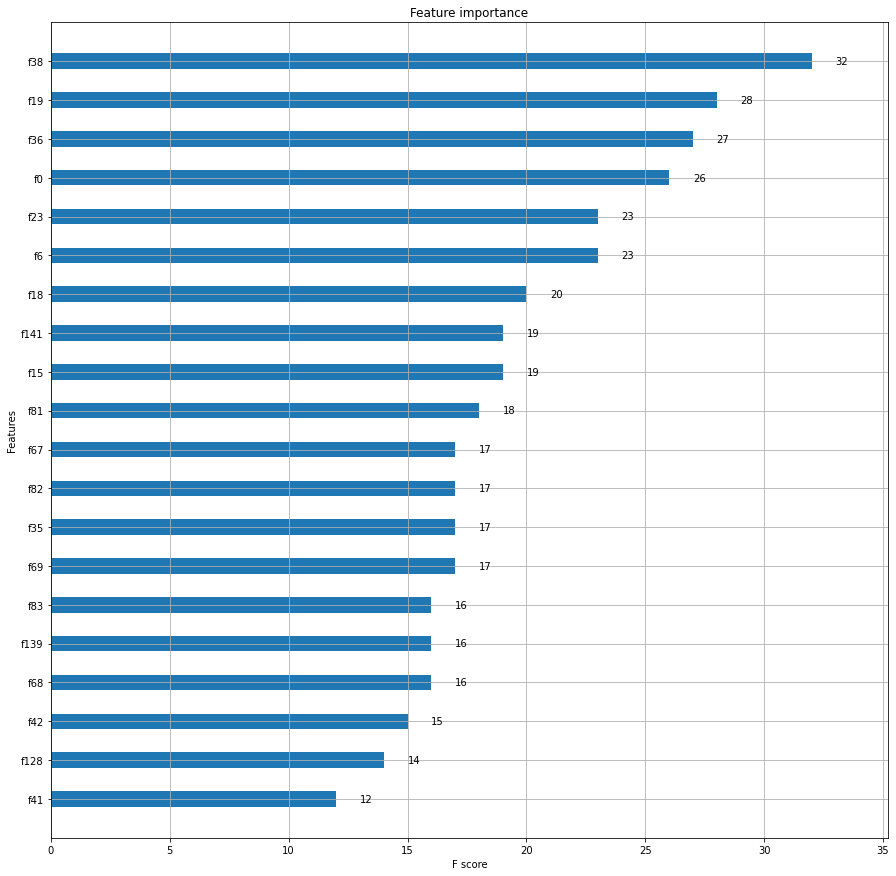

In [50]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
plot_importance(xgb_pipeline.named_steps['xgbclassifier'], ax=ax, max_num_features=20, importance_type='weight', height=0.4);

Another way to look at feature importance is to use 'gain', which calculates the average information gain of splits using the feature

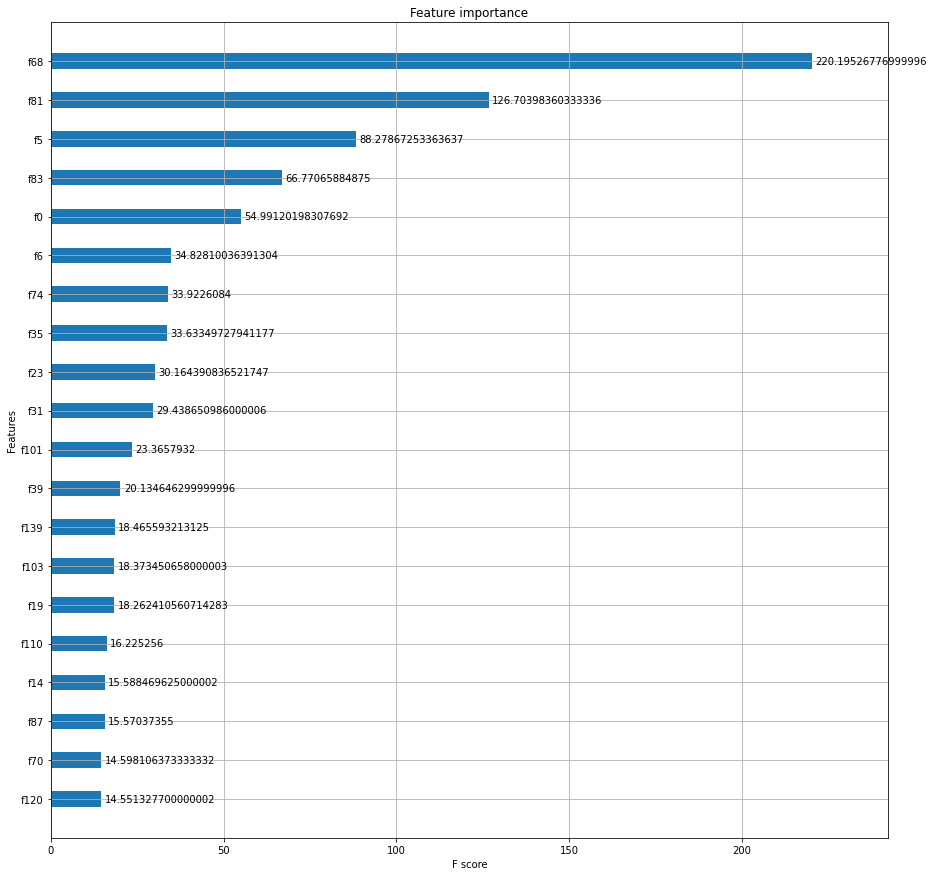

In [51]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
plot_importance(xgb_pipeline.named_steps['xgbclassifier'], ax=ax, max_num_features=20, importance_type='gain', height=0.4);